In [1]:
# Standard
import logging

# Third party
import numpy as np
import rdkit
from rdkit import RDLogger
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import torchmetrics
from torchmetrics import MeanAbsoluteError
import weightwatcher as ww

# GT-PyG
from gt_pyg.data.utils import (
    get_tensor_data, 
    get_node_dim, 
    get_edge_dim, 
    get_train_valid_test_data
)
from gt_pyg.nn.model import GraphTransformerNet
from gt_pyg.util import get_ww_statistic
from gt_pyg.util import get_correction_factor, prepare_params

# Turn off majority of RDKit warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


# Set a random seed for a reproducibility purposes
torch.manual_seed(192837465)

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Log the used versions of RDkit and torch
print(f'Numpy version: {np.__version__}')
print(f'Rdkit version: {rdkit.__version__}')
print(f'Torch version: {torch.__version__}')
print(f'TorchMetrics version: {torchmetrics.__version__}')
print(f'WeightWatcher version: {ww.__version__}')

/Users/pawel/anaconda3/envs/gt/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch is available but CUDA is not. Defaulting to SciPy for SVD


Numpy version: 1.21.6
Rdkit version: 2022.09.5
Torch version: 1.13.1
TorchMetrics version: 0.11.4
WeightWatcher version: 0.7.1.5


## Get the ADME@TDC data

**Note**: To use the code below, make sure that the chosen endpoint is a regression task.

In [2]:
from tdc import utils
names = utils.retrieve_benchmark_names('ADMET_Group')
output = "\n".join([f"{index}. {name}" for index, name in enumerate(names, start=1)])
print("Available endpoints:\n\n" + output)

Available endpoints:

1. caco2_wang
2. hia_hou
3. pgp_broccatelli
4. bioavailability_ma
5. lipophilicity_astrazeneca
6. solubility_aqsoldb
7. bbb_martins
8. ppbr_az
9. vdss_lombardo
10. cyp2d6_veith
11. cyp3a4_veith
12. cyp2c9_veith
13. cyp2d6_substrate_carbonmangels
14. cyp3a4_substrate_carbonmangels
15. cyp2c9_substrate_carbonmangels
16. half_life_obach
17. clearance_microsome_az
18. clearance_hepatocyte_az
19. herg
20. ames
21. dili
22. ld50_zhu


Regression endpoints with MAE metric:
1. caco2_wang (Best: 0.285 ± 0.005)
2. lipophilicity_astrazeneca (Best: 0.535 ± 0.012)
3. solubility_aqsoldb (Best: 0.776 ± 0.008)
4. ppbr_az (Best: 9.185 ± 0.000)
5. ld50_zhu (Best: 0.588 ± 0.005)

In [3]:
PE_DIM = 6
(tr, va, te) = get_train_valid_test_data('ppbr_az', min_num_atoms=0)
tr_dataset = get_tensor_data(tr.Drug.to_list(), tr.Y.to_list(), pe_dim=PE_DIM)
va_dataset = get_tensor_data(va.Drug.to_list(), va.Y.to_list(), pe_dim=PE_DIM)
te_dataset = get_tensor_data(te.Drug.to_list(), te.Y.to_list(), pe_dim=PE_DIM)

NODE_DIM = get_node_dim()
EDGE_DIM = get_edge_dim()

print(f'Number of training examples: {len(tr_dataset)}')
print(f'Number of validation examples: {len(va_dataset)}')
print(f'Number of test examples: {len(te_dataset)}')

train_loader = DataLoader(tr_dataset, batch_size=64)
val_loader = DataLoader(va_dataset, batch_size=512)
test_loader = DataLoader(te_dataset, batch_size=512)

Found local copy...
Loading...
Done!


Number of training examples: 1130
Number of validation examples: 161
Number of test examples: 323


## Train and eval the GT model

### Auxiliary functions

In [4]:
def train(epoch, loss_func, warmup_epochs=5, loader=None):
    model.train()
    train_mae = MeanAbsoluteError()
    
    if epoch > warmup_epochs:
        corrections = get_correction_factor(model, optimizer)
        for idx, val in enumerate(corrections):
            optimizer.param_groups[idx]['lr'] = val * optimizer.param_groups[idx]['base_lr']


    if loader is None:
        loader = train_loader
        
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=False)
        loss = loss_func(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

        train_mae.update(out.squeeze(), data.y)

    return train_mae.compute()


@torch.no_grad()
def test(loader):
    model.eval()
    test_mae = MeanAbsoluteError()

    total_error = 0
    for data in loader:
        data = data.to(device)
        # randomly flip sign of eigenvectors
        batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM)).float() - 1.0)
        (out,_) = model(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
        
        test_mae.update(out.squeeze(), data.y)
        
    return test_mae.compute()

train_loss = nn.L1Loss(reduction='mean')

### Slighlty optimized Graph Transformer architecture

1. `gelu` activation is used instead of `relu`
2. Multiaggregator used for global pooling
3. Multiaggregator used for message passing

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphTransformerNet(node_dim_in=NODE_DIM,
                            edge_dim_in=EDGE_DIM,
                            pe_in_dim=PE_DIM,
                            num_gt_layers=4, 
                            hidden_dim=128,
                            num_heads=8,
                            norm='bn',
                            gt_aggregators=['sum', 'mean'],
                            aggregators=['sum','mean','max', 'std'],
                            dropout=0.1,
                            act='gelu').to(device)

if int(torch.__version__.split('.')[0]) >= 2:
    model = torch_geometric.compile(model) 

lr = 0.001
params = prepare_params(model, lr)
optimizer = torch.optim.AdamW(params)

print(model)
print(f"Number of params: {model.num_parameters()//1000} k")


best_epoch = 0
best_validation_loss = np.inf
test_set_mae = np.inf

epochs_list = []
train_loss_list = []
valid_loss_list = []
test_loss_list = []
ww_list = []

EPOCHS=100
for epoch in range(1, EPOCHS + 1):
    tr_loss = train(epoch, loss_func=train_loss, warmup_epochs=2)
    va_loss = test(val_loader)
    te_loss = test(test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {tr_loss:.4f}, Val: {va_loss:.4f}, '
          f'Test: {te_loss:.4f}')
    if va_loss < best_validation_loss:
        best_epoch = epoch
        best_validation_loss = va_loss
        test_set_mae = te_loss
    
    epochs_list.append(epoch)
    train_loss_list.append(tr_loss)
    valid_loss_list.append(va_loss)
    test_loss_list.append(te_loss)
    ww_list.append(get_ww_statistic(model))
    
print("\nModel's performance on the test set\n"
        "===================================\n"
        f'MAE={test_set_mae}\n'
        f'Epoch={best_epoch}')

GraphTransformerNet(
  (node_emb): Linear(in_features=76, out_features=128, bias=False)
  (edge_emb): Linear(in_features=10, out_features=128, bias=False)
  (pe_emb): Linear(in_features=6, out_features=128, bias=False)
  (gt_layers): ModuleList(
    (0): GTConv(128, 128, heads=8, aggrs: sum,mean)
    (1): GTConv(128, 128, heads=8, aggrs: sum,mean)
    (2): GTConv(128, 128, heads=8, aggrs: sum,mean)
    (3): GTConv(128, 128, heads=8, aggrs: sum,mean)
  )
  (global_pool): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
    MaxAggregation(),
    StdAggregation(),
  ], mode=cat)
  (mu_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (log_var_mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=128, out_featur

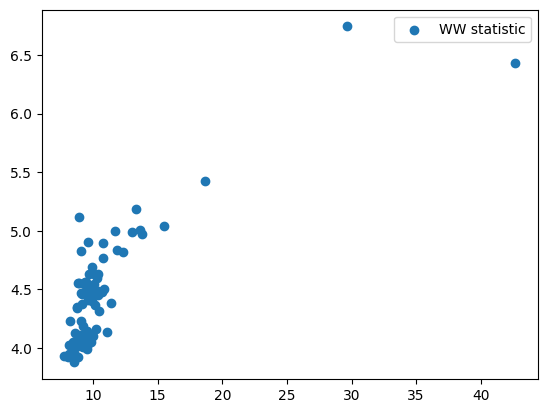

In [6]:
plt.scatter(test_loss_list, ww_list, label='WW statistic')
plt.legend(loc=0)

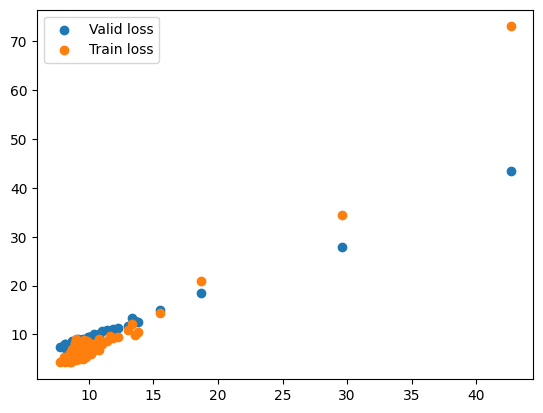

In [7]:
plt.scatter(test_loss_list, valid_loss_list, label='Valid loss')
plt.scatter(test_loss_list, train_loss_list, label='Train loss')
plt.legend(loc=0)

In [8]:
test_loss_list[np.argmin(ww_list)]

tensor(8.5385)

In [9]:
test_loss_list[np.argmin(valid_loss_list)]

tensor(8.5835)

In [10]:
test_loss_list[np.argmin(train_loss_list)]

tensor(8.5385)

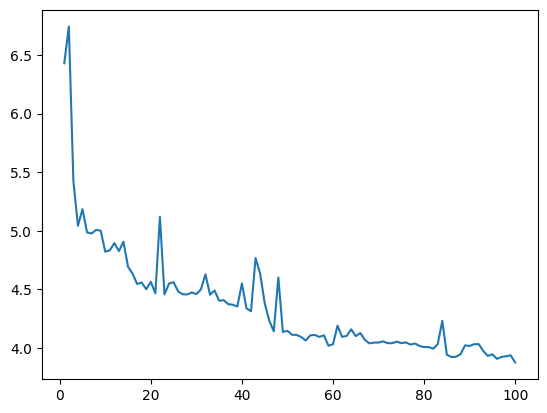

In [11]:
#plt.plot(epochs_list, train_loss_list)
#plt.plot(epochs_list, valid_loss_list)
#plt.plot(epochs_list, test_loss_list)
plt.plot(epochs_list, ww_list)

In [12]:
watcher = ww.WeightWatcher(model=model)
details = watcher.analyze(plot=False)
details

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,entropy,has_esd,...,rf,sigma,spectral_norm,stable_rank,status,sv_max,warning,weak_rank_loss,xmax,xmin
0,1,Linear,0.122949,76,128,1.684211,4.973395,3.236582,0.926830,True,...,1,1.025926,4.474856,22.481977,success,2.115386,,0,4.474856,2.363489
1,2,Linear,0.117601,10,128,12.800000,3.754971,2.743191,0.951755,True,...,1,1.041281,5.377115,4.295238,success,2.318861,,0,5.377115,1.773913
2,11,Linear,0.054225,128,128,1.000000,3.358480,3.520788,0.872303,True,...,1,0.453890,11.177059,13.487674,success,3.343211,,0,11.177059,2.016812
3,12,Linear,0.159696,128,128,1.000000,2.798255,1.651993,0.895927,True,...,1,0.271097,3.893725,33.281034,success,1.973252,,0,3.893725,1.205171
4,13,Linear,0.081044,128,128,1.000000,3.996231,3.282225,0.881519,True,...,1,0.726693,6.627202,22.023015,success,2.574335,,1,6.627202,2.613040
5,14,Linear,0.049863,128,256,2.000000,3.332465,3.437236,0.924163,True,...,1,0.412326,10.750766,19.852441,success,3.278836,,0,10.750766,2.261996
6,15,Linear,0.079410,128,128,1.000000,3.484427,4.679551,0.847146,True,...,1,0.496885,22.028764,7.017210,success,4.693481,,1,22.028764,2.034805
7,16,Linear,0.112982,128,128,1.000000,3.934383,3.203324,0.882510,True,...,1,0.673194,6.519092,24.837336,success,2.553251,,0,6.519092,2.778342
8,19,Linear,0.086711,128,128,1.000000,4.497365,1.507070,0.886656,True,...,1,0.848236,2.163220,22.412828,success,1.470789,,0,2.163220,0.883871
9,22,Linear,0.095188,128,128,1.000000,3.880667,1.048817,0.889625,True,...,1,0.588014,1.863233,24.716977,success,1.365003,,0,1.863233,0.696106


In [13]:
watcher.get_summary(details)

{'log_norm': 1.9617880817975497,
 'alpha': 3.8759143081438427,
 'alpha_weighted': 2.5125688359017633,
 'log_alpha_norm': 3.029487412316085,
 'log_spectral_norm': 0.6560423502811896,
 'stable_rank': 22.397062682171264}

Text(0, 0.5, 'alpha')

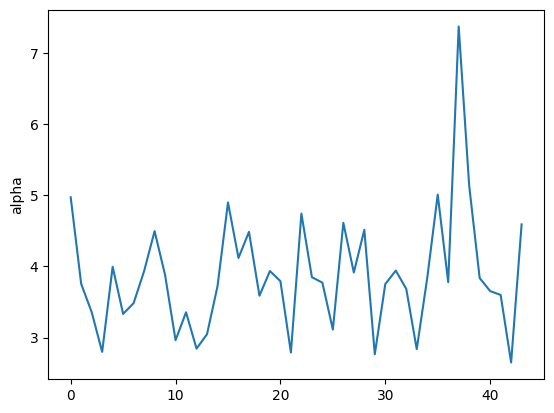

In [17]:
plt.plot(list(range(len(details))), details.alpha.to_list())
plt.ylabel('layer_id')
plt.ylabel('alpha')